In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

Load data

In [2]:
tr_set = np.genfromtxt('lab2_1_data.csv', delimiter=',').T # Transpose to get standard format: row==sample
tr_set.shape

(100, 2)

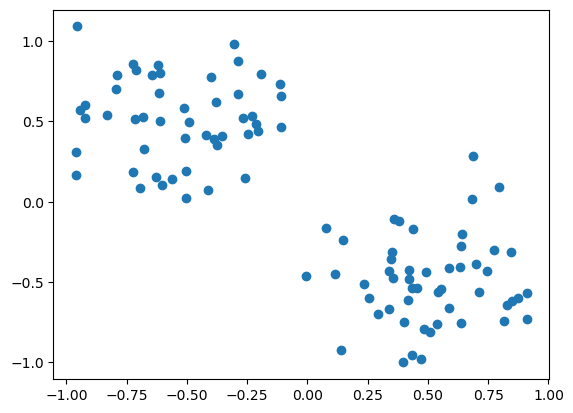

In [3]:
plt.scatter(tr_set[:, 0], tr_set[:, 1])
plt.show()

In [4]:
import json
def plot_results(w_history_batch, title='', filename=''):

    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(14, 10)

    # First weight component
    axes[0][0].plot(w_history_batch[:, 0])
    axes[0][0].set_ylabel('W_1')
    axes[0][0].set_xlabel('training steps')

    # Second weight component
    axes[0][1].plot(w_history_batch[:, 1])
    axes[0][1].set_ylabel('W_2')
    axes[0][1].set_xlabel('training steps')

    # Calculate norm history of the weights
    w_history_batch_norm = np.array([np.linalg.norm(w) for w in w_history_batch])
    axes[1][0].plot(w_history_batch_norm)
    axes[1][0].set_ylabel('Weights norm')
    axes[1][0].set_xlabel('training steps')

    # Calculate input correlation matrix Q
    Q = np.dot(tr_set.T, tr_set)
    # Caluclate Q principal eigenvector
    eigvals, eigvecs = np.linalg.eig(Q)
    principal_eigvec = eigvecs[:, np.argmax(eigvals)] # Principal eigenvector is the one corresponding to the largest eigenvalue

    final_weight = w_history_batch[-1]
    axes[1][1].scatter(tr_set[:, 0], tr_set[:, 1])
    quiver_Q = axes[1][1].quiver(0.01, 0.01, principal_eigvec[0], principal_eigvec[1], color='blue', label='Princ. eigvec. Q')
    quiver__w = axes[1][1].quiver(0, 0, final_weight[0], final_weight[1], color='red', label='Final direction of weights')
    axes[1][1].legend()

    if title != '':
        plt.suptitle(title)

    # Save w_history_batch as a json file
    if filename != '':
        json_file = os.path.join('output', filename + '.json')
        with open(json_file, 'w') as f:
            json.dump(w_history_batch.tolist(), f)
        
        # Save the plot as a png file
        png_file = os.path.join('output', filename + '.png')
        plt.savefig(png_file)

    plt.show()

# Assignemnt 1 - Basic Hebbian Learning

In [5]:
def train_hebbian_learning(tr_set, lr=1e-3, max_epochs=200, early_stopping_thresh = 0.00001, batch_size=1):
    w_init = np.random.rand(2)*2 -1 # Scale the random weight initialization to [-1, 1]
    
    w_history_batch = [w_init] # History of weights for each batch in tr 
    w_history_epoch = [w_init] # History of at the end of each epoch in tr 
    w = w_init

    num_samples = tr_set.shape[0]

    for epoch in range(max_epochs):
        # Shuffle the input
        shuffled_tr_set = np.random.permutation(tr_set)

        start_batch_idx = 0

        while start_batch_idx < num_samples:
            # Define batch
            end_batch_idx = start_batch_idx + batch_size 
            if end_batch_idx > num_samples:
                end_batch_idx = num_samples
            batch = shuffled_tr_set[start_batch_idx : end_batch_idx]
            u = batch

            # Adjust learning rate if the last batch is smaller than normal
            curr_batch_size = end_batch_idx - start_batch_idx
            if curr_batch_size != batch_size:
                batch_lr = lr * (curr_batch_size/batch_size)
            else: 
                batch_lr = lr

            # Calcuate Hebb Rule
            v = np.dot(w, u.T) # v dim: (batch_size,)
            new_w = w + batch_lr * np.dot(v, u) # new_w dim: (num_features)

            # Save batch weights
            w = new_w
            w_history_batch.append(w)

            # Update start index of new batch
            start_batch_idx += batch_size
        
        # Add weigths of last batches to epoch history
        w_history_epoch.append(w_history_batch[-1]) 


        # Stopping condition: check if norm of weights difference at the end of current and last epoch is under thresh
        if np.linalg.norm(w_history_epoch[-1]-w_history_epoch[-2]) < early_stopping_thresh:
            print('Stopped at epoch:', epoch)
            break


    print('Stopped at epoch:', epoch)
    return np.array(w_history_epoch), np.array(w_history_batch)

Experiment different batch sizes

Stopped at epoch: 199


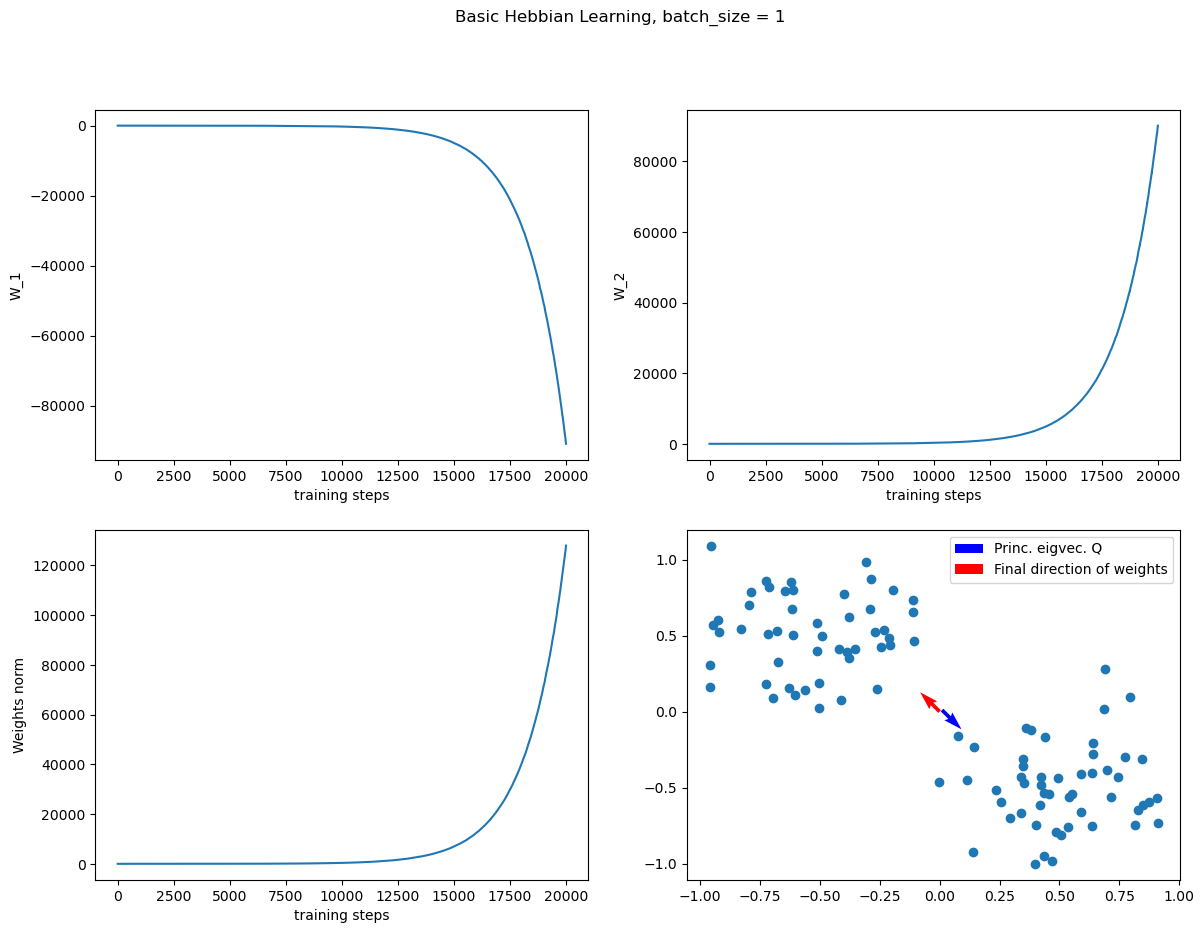

In [6]:
lr = 1e-3
batch_size = 1


w_history_epoch, w_history_batch = train_hebbian_learning(tr_set, lr=lr, batch_size=batch_size)
plot_results(w_history_batch, title='Basic Hebbian Learning, batch_size = {}'.format(batch_size), filename='hebbian_batch_{}'.format(batch_size))


Stopped at epoch: 199


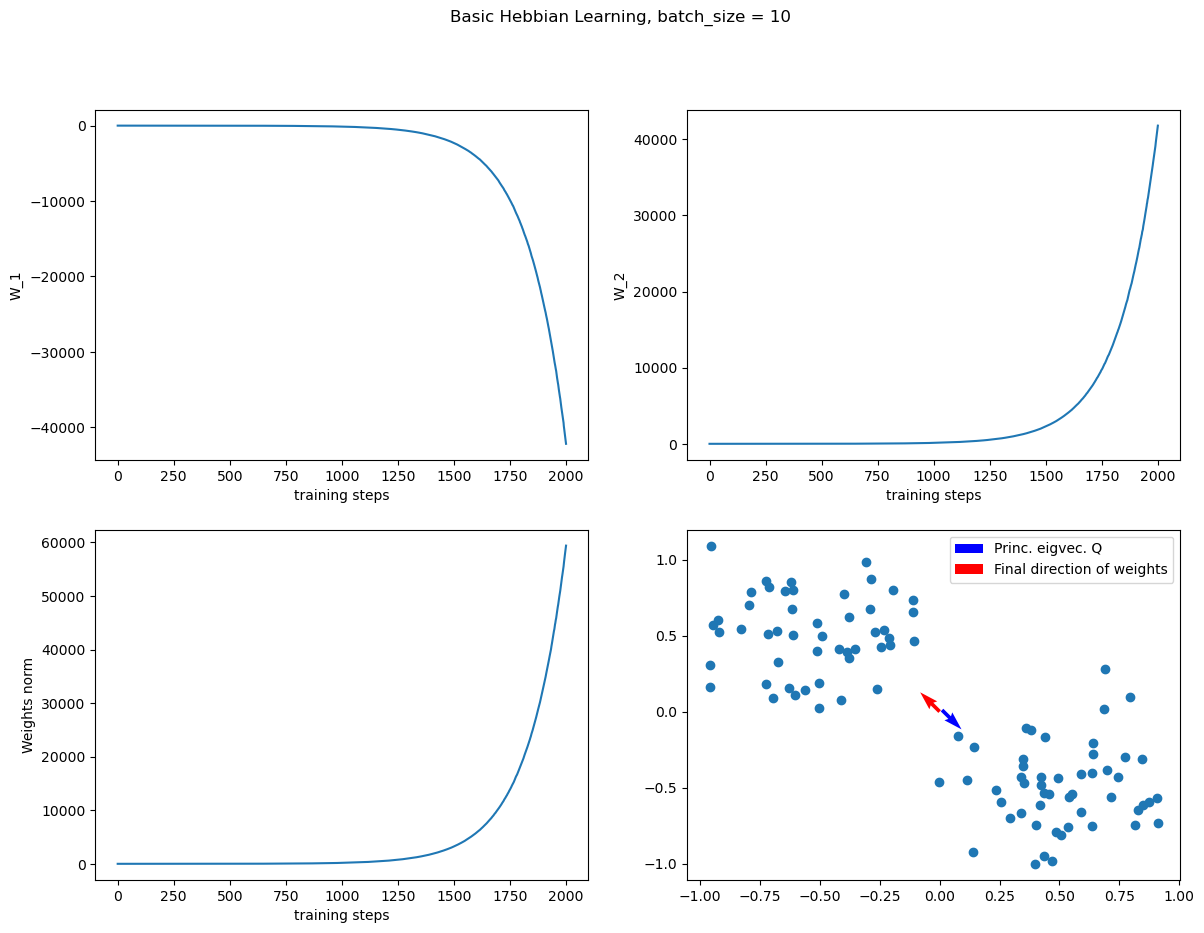

In [7]:
lr = 1e-3
batch_size = 10


w_history_epoch, w_history_batch = train_hebbian_learning(tr_set, lr=lr, batch_size=batch_size)
plot_results(w_history_batch, title='Basic Hebbian Learning, batch_size = {}'.format(batch_size), filename='hebbian_batch_{}'.format(batch_size))

Stopped at epoch: 199


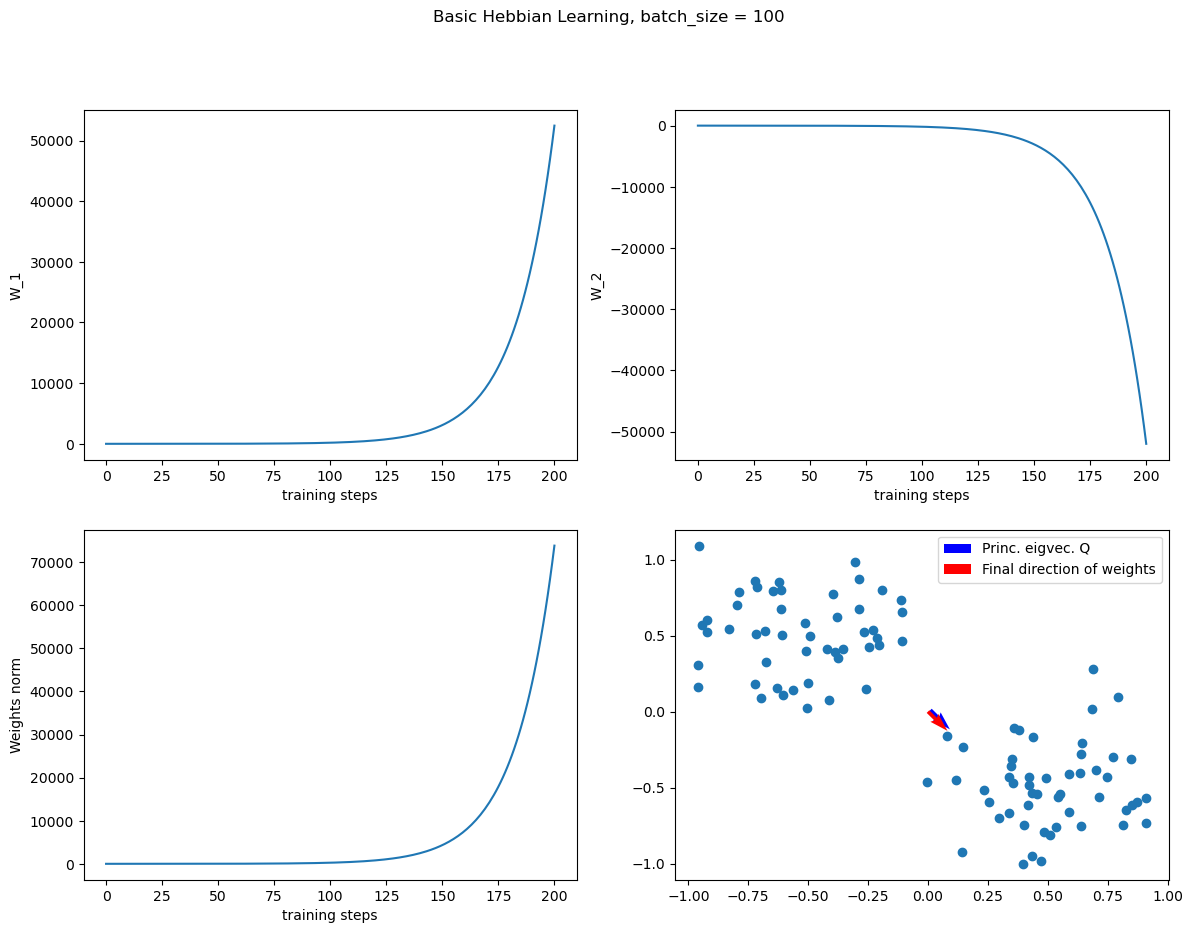

In [8]:
lr = 1e-3
batch_size = 100


w_history_epoch, w_history_batch = train_hebbian_learning(tr_set, lr=lr, batch_size=batch_size)
plot_results(w_history_batch, title='Basic Hebbian Learning, batch_size = {}'.format(batch_size), filename='hebbian_batch_{}'.format(batch_size))

The direction of the weight vector is always the same to the principal eigenvector of Q, sometimes with opposite sign. 

# Assignment 2 - Oja rule

In [9]:
def train_hebbian_learning_oja(tr_set, lr=1e-3, max_epochs=200, early_stopping_thresh = 0.00001, batch_size=1, alpha=0.1):
    w_init = np.random.rand(2)*2 -1 # Scale the random weight initialization to [-1, 1]
    
    w_history_batch = [w_init] # History of weights for each batch in tr 
    w_history_epoch = [w_init] # History of at the end of each epoch in tr 
    w = w_init

    num_samples = tr_set.shape[0]

    for epoch in range(max_epochs):
        # Shuffle the input
        shuffled_tr_set = np.random.permutation(tr_set)

        start_batch_idx = 0

        while start_batch_idx < num_samples:
            # Define batch
            end_batch_idx = start_batch_idx + batch_size 
            if end_batch_idx > num_samples:
                end_batch_idx = num_samples
            batch = shuffled_tr_set[start_batch_idx : end_batch_idx]
            u = batch

            # Adjust learning rate if the last batch is smaller than normal
            curr_batch_size = end_batch_idx - start_batch_idx
            if curr_batch_size != batch_size:
                batch_lr = lr * (curr_batch_size/batch_size)
            else: 
                batch_lr = lr

            # Calcuate Oja Rule
            v = np.dot(w, u.T) # v dim: (batch_size,)
            new_w = w + batch_lr * np.dot(v, u) - alpha * np.dot(v, v) * w # new_w dim: (num_features)

            # Save batch weights
            w = new_w
            w_history_batch.append(w)

            # Update start index of new batch
            start_batch_idx += batch_size
        
        # Add weigths of last batches to epoch history
        w_history_epoch.append(w_history_batch[-1]) 


        # Stopping condition: check if norm of weights difference at the end of current and last epoch is under thresh
        if np.linalg.norm(w_history_epoch[-1]-w_history_epoch[-2]) < early_stopping_thresh:
            print('Stopped at epoch:', epoch)
            break

    print('Stopped at epoch:', epoch)
    return np.array(w_history_epoch), np.array(w_history_batch)

Stopped at epoch: 120
Stopped at epoch: 120


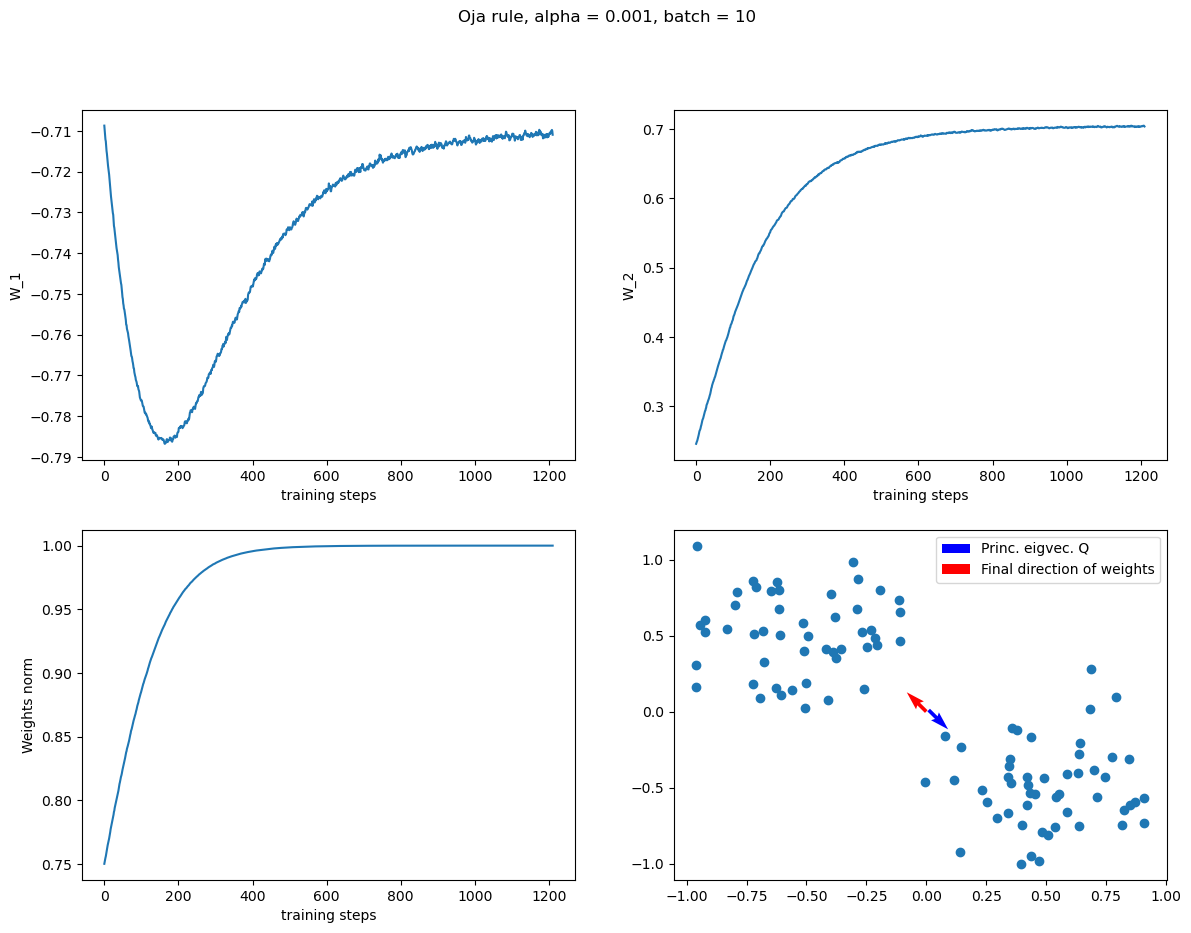

Stopped at epoch: 134
Stopped at epoch: 134


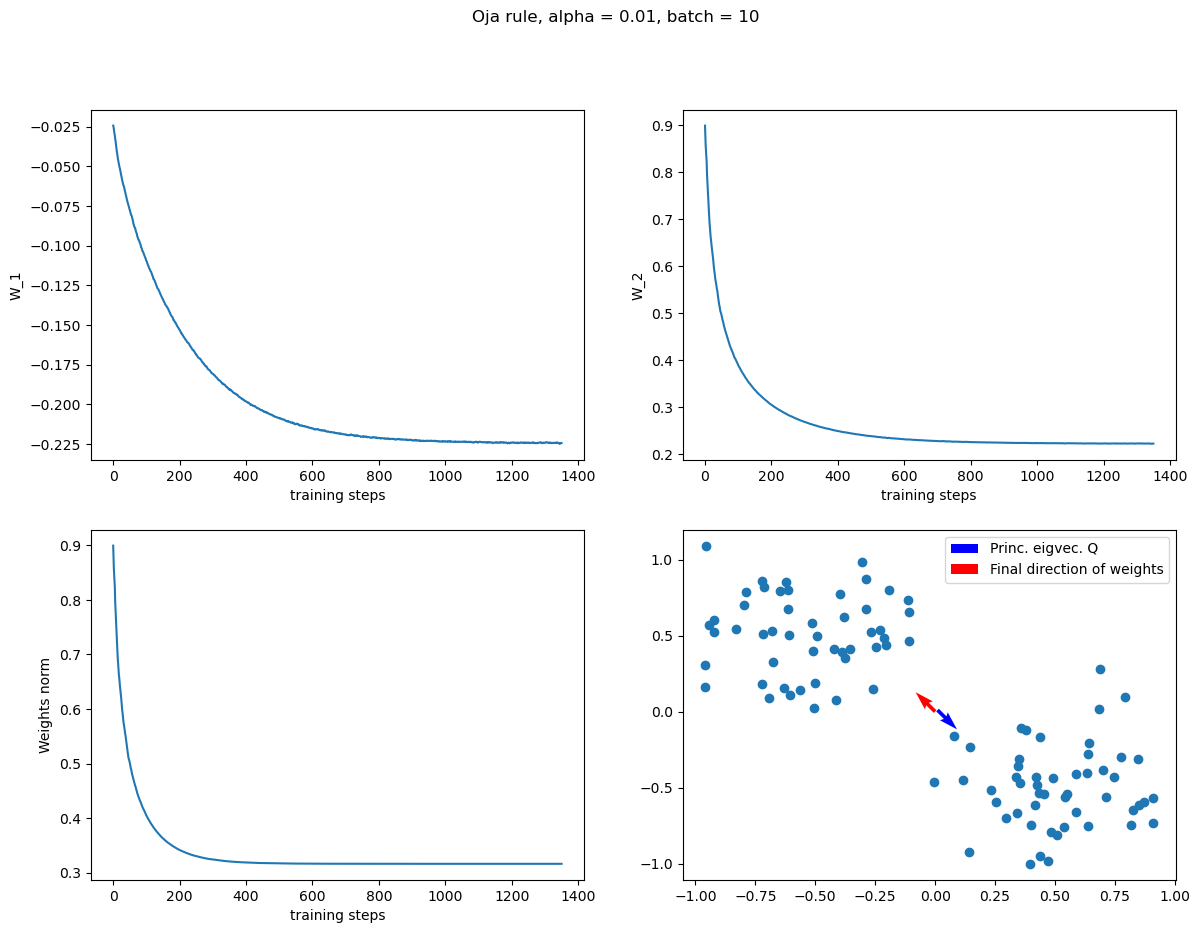

Stopped at epoch: 81
Stopped at epoch: 81


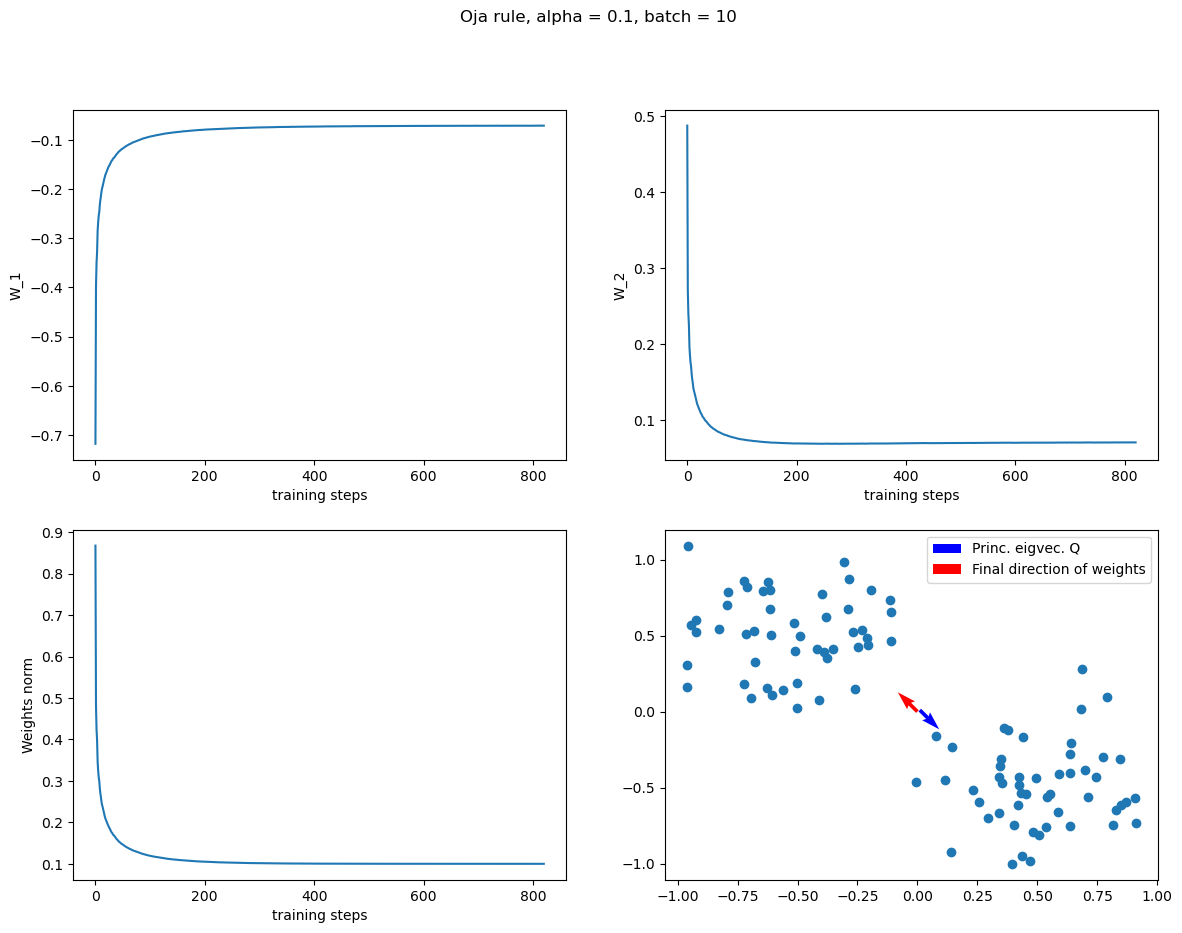

In [10]:
alpha_list = [0.001, 0.01, 0.1]

for alpha in alpha_list:
    w_history_epoch, w_history_batch = train_hebbian_learning_oja(tr_set, lr=1e-3, batch_size=10, alpha=alpha)
    plot_results(w_history_batch, title='Oja rule, alpha = {}, batch = {}'.format(alpha, 10), filename='oja_rule_alpha_{}_batch_{}'.format(alpha, 10))

**alpha = 0.1** seems to be the best.

# Assignment 3 - Subtractive normalization

In [11]:
def train_hebbian_learning_subtractive_norm_old(tr_set, lr=1e-3, max_epochs=200, early_stopping_thresh = 0.00001, batch_size=1):
    w_init = np.random.rand(2)*2 -1 # Scale the random weight initialization to [-1, 1]
    
    w_history_batch = [w_init] # History of weights for each batch in tr 
    w_history_epoch = [w_init] # History of at the end of each epoch in tr 
    w = w_init

    num_samples = tr_set.shape[0]

    for epoch in range(max_epochs):
        # Shuffle the input
        shuffled_tr_set = np.random.permutation(tr_set)

        start_batch_idx = 0

        while start_batch_idx < num_samples:
            # Define batch
            end_batch_idx = start_batch_idx + batch_size 
            if end_batch_idx > num_samples:
                end_batch_idx = num_samples
            batch = shuffled_tr_set[start_batch_idx : end_batch_idx]
            u = batch

            # Adjust learning rate if the last batch is smaller than normal
            curr_batch_size = end_batch_idx - start_batch_idx
            if curr_batch_size != batch_size:
                batch_lr = lr * (curr_batch_size/batch_size)
            else: 
                batch_lr = lr

            # Subtrctive normalization Rule
            num_features = u.shape[1]
            n = np.ones((num_features, 1)) # dim : (num_features,)

            v = np.dot(w, u.T) # v dim: (batch_size,)

            subtr_norm = np.dot(v.T, np.dot(np.dot(u, n), n.T)) / num_features # dim: (num_features,)
            new_w = w + batch_lr * np.dot(v, u) - subtr_norm # new_w dim: (num_features)

            # Save batch weights
            w = new_w
            w_history_batch.append(w)

            # Update start index of new batch
            start_batch_idx += batch_size
        
        # Add weigths of last batches to epoch history
        w_history_epoch.append(w_history_batch[-1]) 


        # Stopping condition: check if norm of weights difference at the end of current and last epoch is under thresh
        if np.linalg.norm(w_history_epoch[-1]-w_history_epoch[-2]) < early_stopping_thresh:
            print('Stopped at epoch:', epoch)
            break

    print('Stopped at epoch:', epoch)
    return np.array(w_history_epoch), np.array(w_history_batch)

In [12]:
def train_hebbian_learning_subtractive_norm(tr_set, lr=1e-3, max_epochs=200, early_stopping_thresh = 0.00001):
    w_init = np.random.rand(2)*2 -1 # Scale the random weight initialization to [-1, 1]
    
    w_history = [w_init] # History of weights for each batch in tr 
    w_history_epoch = [w_init] # History of at the end of each epoch in tr 
    w = w_init

    num_samples = tr_set.shape[0]

    for epoch in range(max_epochs):
        # Shuffle the input
        shuffled_tr_set = np.random.permutation(tr_set)

        for u in shuffled_tr_set:
            # Subtrctive normalization Rule
            num_features = u.shape[0]
            n = np.ones((num_features,)) # dim : (num_features,)

            v = np.dot(w, u.T) # v dim: (batch_size,)

            subtr_norm =  v*(np.dot(u, n.T)*n) / num_features # dim: (num_features,)
            new_w = w + lr * (v*u - subtr_norm) # new_w dim: (num_features)

            # Save batch weights
            w = new_w
            w_history.append(w)
        
        # Add weigths of last batches to epoch history
        w_history_epoch.append(w_history[-1]) 


        # Stopping condition: check if norm of weights difference at the end of current and last epoch is under thresh
        if np.linalg.norm(w_history_epoch[-1]-w_history_epoch[-2]) < early_stopping_thresh:
            print('Stopped at epoch:', epoch)
            break

    print('Stopped at epoch:', epoch)
    return np.array(w_history_epoch), np.array(w_history)

Stopped at epoch: 199


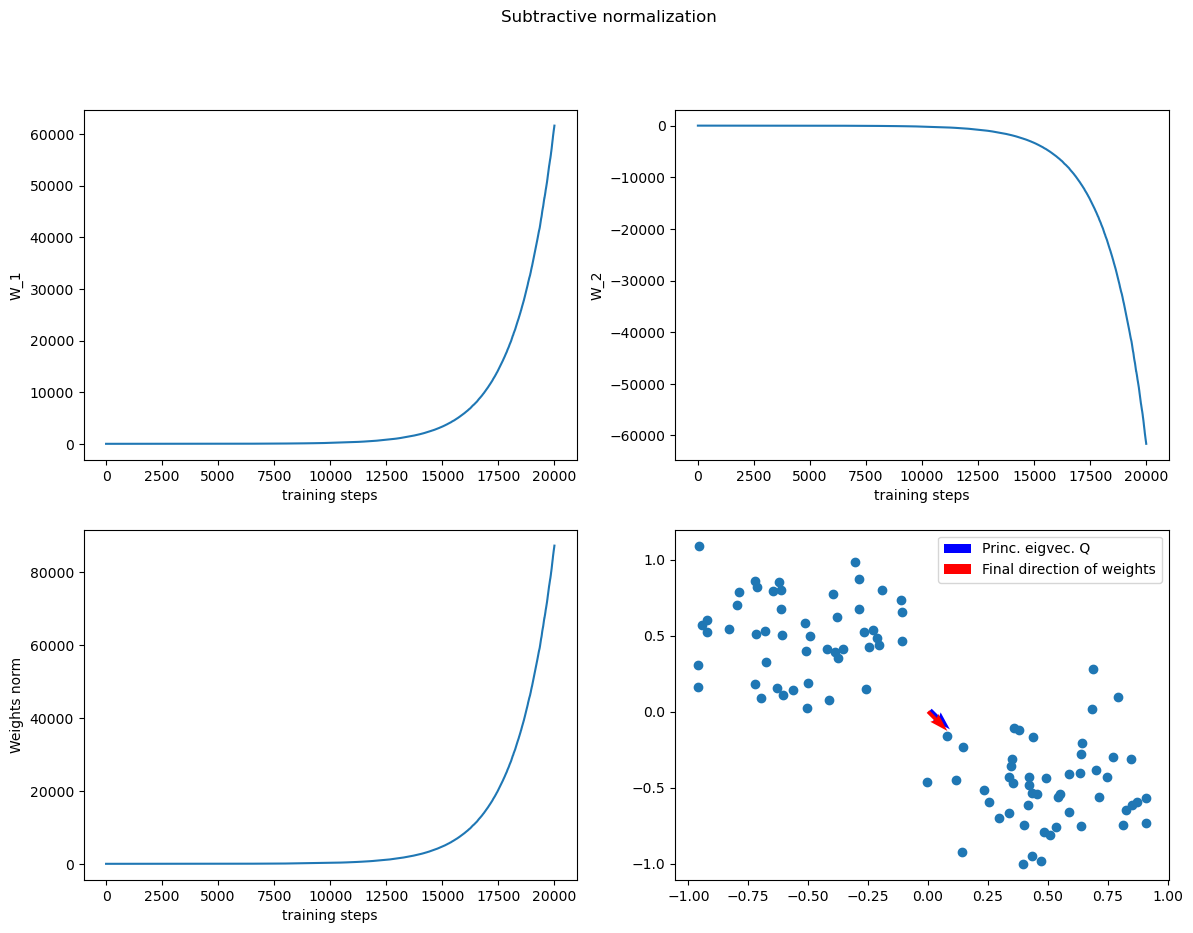

In [13]:
batch_size = 1
lr = 1e-3


w_history_epoch, w_history_batch = train_hebbian_learning_subtractive_norm(tr_set, lr=lr,)
plot_results(w_history_batch, title='Subtractive normalization', filename='subtractive_normalization')